In [2]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import datetime
import seaborn as sns


In [3]:
#import ML models

from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


In [4]:
from IPython.core.display import HTML
css = open('../Data/style-table.css').read() + open('../Data/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [5]:
#imports the raw data in chunks. SQL export could not accomodate one CSV dump

USMTO1 = pd.DataFrame.from_csv('../Data/USMTO1.norm.csv', index_col = False)
USMTO2 = pd.DataFrame.from_csv('../Data/USMTO2.norm.csv', index_col = False)
USMTO3 = pd.DataFrame.from_csv('../Data/USMTO3.norm.csv', index_col = False)
USMTO4 = pd.DataFrame.from_csv('../Data/USMTO4.norm.csv', index_col = False)
USMTO5 = pd.DataFrame.from_csv('../Data/USMTO5.norm.csv', index_col = False)

In [6]:
#imports raw data for S&P 500 values and Industrial Production

SP_500 = pd.DataFrame.from_csv('../Data/SP_500.csv', index_col = False)

In [7]:
#re-combines raw data

USMTO_WHOLE = USMTO1.append(USMTO2).append(USMTO3).append(USMTO4).append(USMTO5)

In [8]:
#merges external data with USMTO data

USMTO_WHOLE = USMTO_WHOLE.merge(SP_500, how='inner', on = ['EntryMonth', 'EntryYear'])

In [9]:
#format order date to datetime to prepare for analysis

USMTO_WHOLE['OrderDateFormatted'] = pd.to_datetime(USMTO_WHOLE.OrderDate)

In [10]:
#format changed date to datetime to prepare for analysis

USMTO_WHOLE['ChangedDateFormatted'] = pd.to_datetime(USMTO_WHOLE.ChangedDate)

In [11]:
#format submit date to datetime to prepare for analysis

USMTO_WHOLE['SubmitDateFormatted'] = pd.to_datetime(USMTO_WHOLE.SubmitDate.fillna(''))

In [12]:
#more formatting to get Order Date at End of Month

USMTO_WHOLE['hyphen'] = "-"

USMTO_WHOLE['OrderDateEOM'] = (USMTO_WHOLE.EntryYear.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.EntryMonth.astype(str)) + (USMTO_WHOLE.hyphen) + (USMTO_WHOLE.OrderDateFormatted.dt.days_in_month.astype(str))

In [13]:
#format OrderDateEOM to datetime

USMTO_WHOLE['OrderDateEOM'] = pd.to_datetime(USMTO_WHOLE['OrderDateEOM'])


In [14]:
#create column DaysLate which indicates how many days late the order was submitted

USMTO_WHOLE['DaysLate'] = (USMTO_WHOLE['SubmitDateFormatted'] - USMTO_WHOLE['OrderDateEOM']).dt.days - 10

In [15]:
#fill all NaN with "0" -> count=141

USMTO_WHOLE['DaysLate'] = USMTO_WHOLE['DaysLate'].fillna('0')

In [16]:
#cast DaysLate and TotalSale as float64

USMTO_WHOLE['DaysLate'] = pd.to_numeric(USMTO_WHOLE['DaysLate'])
USMTO_WHOLE['TotalSale'] = (USMTO_WHOLE['TotalSale'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [17]:
#drop un-needed columns

USMTO_WHOLE = USMTO_WHOLE.drop('SubmitDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('OrderDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('ChangedDate', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsCancel', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('CancelOrderID', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('hyphen', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsMatch', axis=1)
USMTO_WHOLE = USMTO_WHOLE.drop('IsIgnore', axis=1)


In [18]:
#creates columns IsEmailOne, IsEmailTwo, IsCall indicating when reminders are made for a member to submit

USMTO_WHOLE['IsEmailOne'] = USMTO_WHOLE['DaysLate'] >= 1
USMTO_WHOLE.IsEmailOne = USMTO_WHOLE.IsEmailOne.astype('int')       

USMTO_WHOLE['IsEmailTwo'] = USMTO_WHOLE['DaysLate'] >= 5
USMTO_WHOLE.IsEmailTwo = USMTO_WHOLE.IsEmailTwo.astype('int')    

USMTO_WHOLE['IsCall'] = USMTO_WHOLE['DaysLate'] >= 10
USMTO_WHOLE.IsCall = USMTO_WHOLE.IsCall.astype('int')

USMTO_WHOLE['IsBackfill'] = USMTO_WHOLE['DaysLate'] >= 90
USMTO_WHOLE.IsBackfill = USMTO_WHOLE.IsBackfill.astype('int')

USMTO_WHOLE.to_csv('../Data/Intermediate.csv')

#caches the data

In [19]:
#import from cache to save time

USMTO_WHOLE = pd.DataFrame.from_csv('../Data/Intermediate.csv', index_col = False)

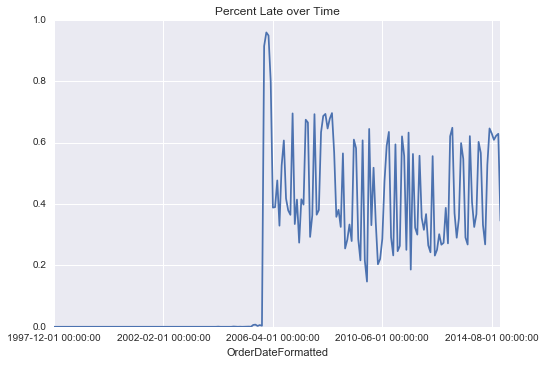

In [20]:
#shows the need to truncate data set and dump data before 2006

USMTO_WHOLE.groupby(['OrderDateFormatted'])['IsEmailOne'].mean().plot(kind = 'line', title = 'Percent Late over Time')

In [21]:
#tosses the former half of data which may not be relevant

USMTO_WHOLE = USMTO_WHOLE[(USMTO_WHOLE.OrderDateFormatted >= '2006-05-01')]

In [22]:
#shows columns of cleaned dataset

USMTO_WHOLE.columns

Index(['Unnamed: 0', 'OrderID', 'AAID', 'NAICSID', 'CustomerZipCode',
       'ShippingCountryID', 'ShippingZipCode', 'Units', 'TotalSale',
       'CreatedBy', 'CreateDate', 'ChangedBy', 'IsSubmitted',
       'TopCategoryName', 'SubCategory', 'SubCategoryName', 'Description',
       'MachineCode', 'EntryMonth', 'EntryYear', 'Date', 'Close', 'IP',
       'OrderDateFormatted', 'ChangedDateFormatted', 'SubmitDateFormatted',
       'OrderDateEOM', 'DaysLate', 'IsEmailOne', 'IsEmailTwo', 'IsCall',
       'IsBackfill'],
      dtype='object')

In [23]:
#create two new tables, one without outliers (outside 2 stdev), and one without backfillers (defined as submitted later than 100 days - per company definition)

USMTO_NO_SUBMIT_OUTLIERS = USMTO_WHOLE[np.abs(USMTO_WHOLE.DaysLate-USMTO_WHOLE.DaysLate.mean())<=(2*USMTO_WHOLE.DaysLate.std())] 
USMTO_NO_SUBMIT_BACKFILL = USMTO_WHOLE[USMTO_WHOLE.DaysLate <= 90]

#source: http://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe


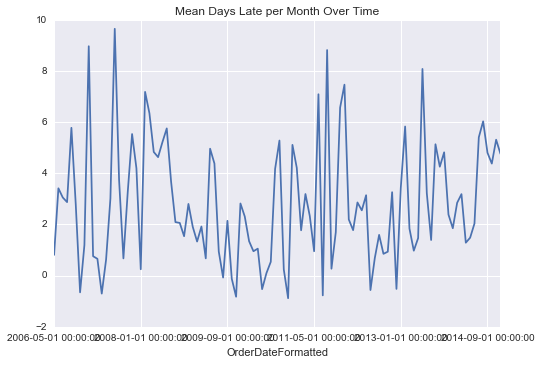

In [24]:
#Plots days late in a time series to see changes over time

USMTO_NO_SUBMIT_BACKFILL.groupby(['OrderDateFormatted'])['DaysLate'].mean().plot(kind = 'line', title = 'Mean Days Late per Month Over Time')

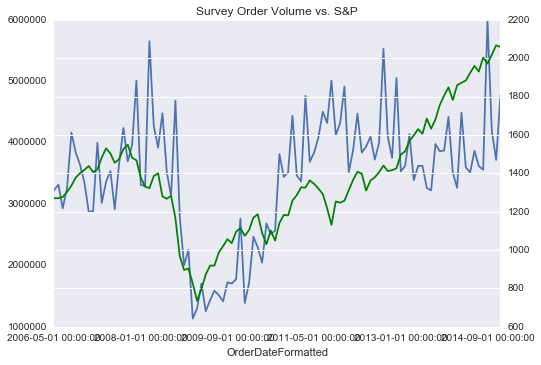

In [77]:
#shows similarity between survey orders and S&P

AAID_BY_MONTH.groupby(['OrderDateFormatted'])['TotalSale'].mean().plot(kind = 'line', title = 'Survey Order Volume vs. S&P')
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['Close'].mean().plot(kind = 'line', secondary_y=True, style= 'g')

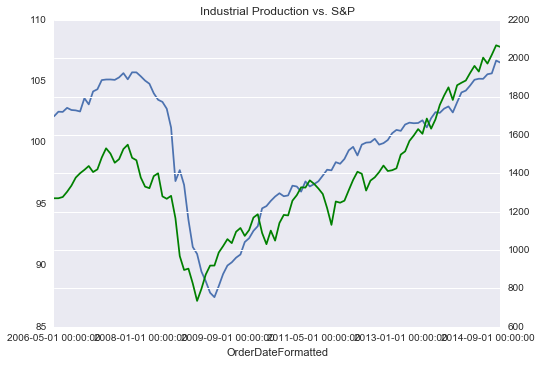

In [78]:
#shows similarity between IP and S&P

AAID_BY_MONTH.groupby(['OrderDateFormatted'])['IP'].mean().plot(kind = 'line', title = 'Industrial Production vs. S&P')
AAID_BY_MONTH.groupby(['OrderDateFormatted'])['Close'].mean().plot(kind = 'line', secondary_y=True, style= 'g')

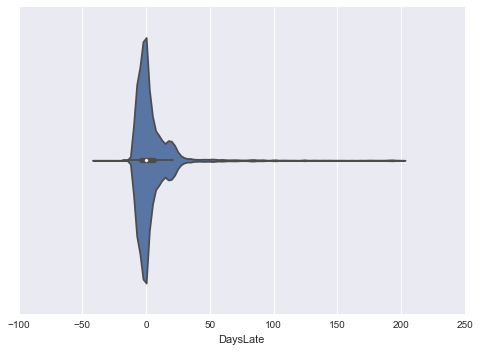

In [28]:
#plots distribution of days late - shows problem is not "endemic" but most rather participants are OK at submitting

sns.violinplot(USMTO_NO_SUBMIT_OUTLIERS.DaysLate, title = 'Distribution of Days Late, 1997 to present')


In [29]:
#Creates table that groups by AAID and OrderDateFormatted

AAID_BY_MONTH = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['DaysLate','TotalSale','IsEmailOne', 'IsEmailTwo', 'IsCall', 'IsBackfill','Close','IP'].mean()
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2 = USMTO_WHOLE.groupby(['AAID','OrderDateFormatted'])['Units','TotalSale'].sum()
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH_2.reset_index(level=1, inplace=True)
AAID_BY_MONTH = AAID_BY_MONTH.merge(AAID_BY_MONTH_2, how = 'inner', on = ['AAID','OrderDateFormatted'])
AAID_BY_MONTH['TotalSaleAvg'] = AAID_BY_MONTH['TotalSale_x']
AAID_BY_MONTH['TotalSale'] = AAID_BY_MONTH['TotalSale_y']
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_x', axis = 1)
AAID_BY_MONTH = AAID_BY_MONTH.drop('TotalSale_y', axis = 1)
AAID_BY_MONTH.head()

,AAID,OrderDateFormatted,DaysLate,IsEmailOne,IsEmailTwo,IsCall,IsBackfill,Close,IP,Units,TotalSaleAvg,TotalSale
0,123,2007-12-01 00:00:00,522.0,1,1,1,1,1468.359985,105.7256,13,18461.538462,240000.0
1,123,2010-10-01 00:00:00,673.0,1,1,1,1,1183.260010,95.6362,2,100000.000000,200000.0
2,100005,2006-05-01 00:00:00,-5.0,0,0,0,0,1270.089966,102.1531,7,131438.714286,920071.0
3,100005,2006-06-01 00:00:00,1.0,1,0,0,0,1270.199951,102.5220,2,153945.500000,307891.0
4,100005,2006-07-01 00:00:00,-8.0,0,0,0,0,1276.660034,102.5057,11,57971.090909,637682.0


In [81]:
#imports tables to work on, created from CreateAAIDByMonth

AAID_BY_MONTH_NO_BACKFILL = pd.DataFrame.from_csv('../Data/result.csv', index_col = False)
AAID_BY_MONTH_NO_BACKFILL = AAID_BY_MONTH_NO_BACKFILL.fillna(value = 0)

In [82]:
#shows columns of table we are about to work with

AAID_BY_MONTH_NO_BACKFILL.columns

Index(['Unnamed: 0', 'AAID', 'OrderDateFormatted', 'DaysLate', 'IsEmailOne',
       'IsEmailTwo', 'IsCall', 'IsBackfill', 'Close', 'IP', 'Units',
       'TotalSaleAvg', 'TotalSale', 'UnitsLast', 'IsCallLast',
       'TotalSaleAvgLast', 'TotalSaleLastThree', 'DaysLateLastThree',
       'DaysLateLast'],
      dtype='object')

In [83]:
#exports days late by aaid for further analysis internally

b = AAID_BY_MONTH_NO_BACKFILL.groupby(['AAID'])['DaysLate'].mean()
c = pd.DataFrame(b)
c.to_csv('../Data/DaysLateByAAID',sep = ',')

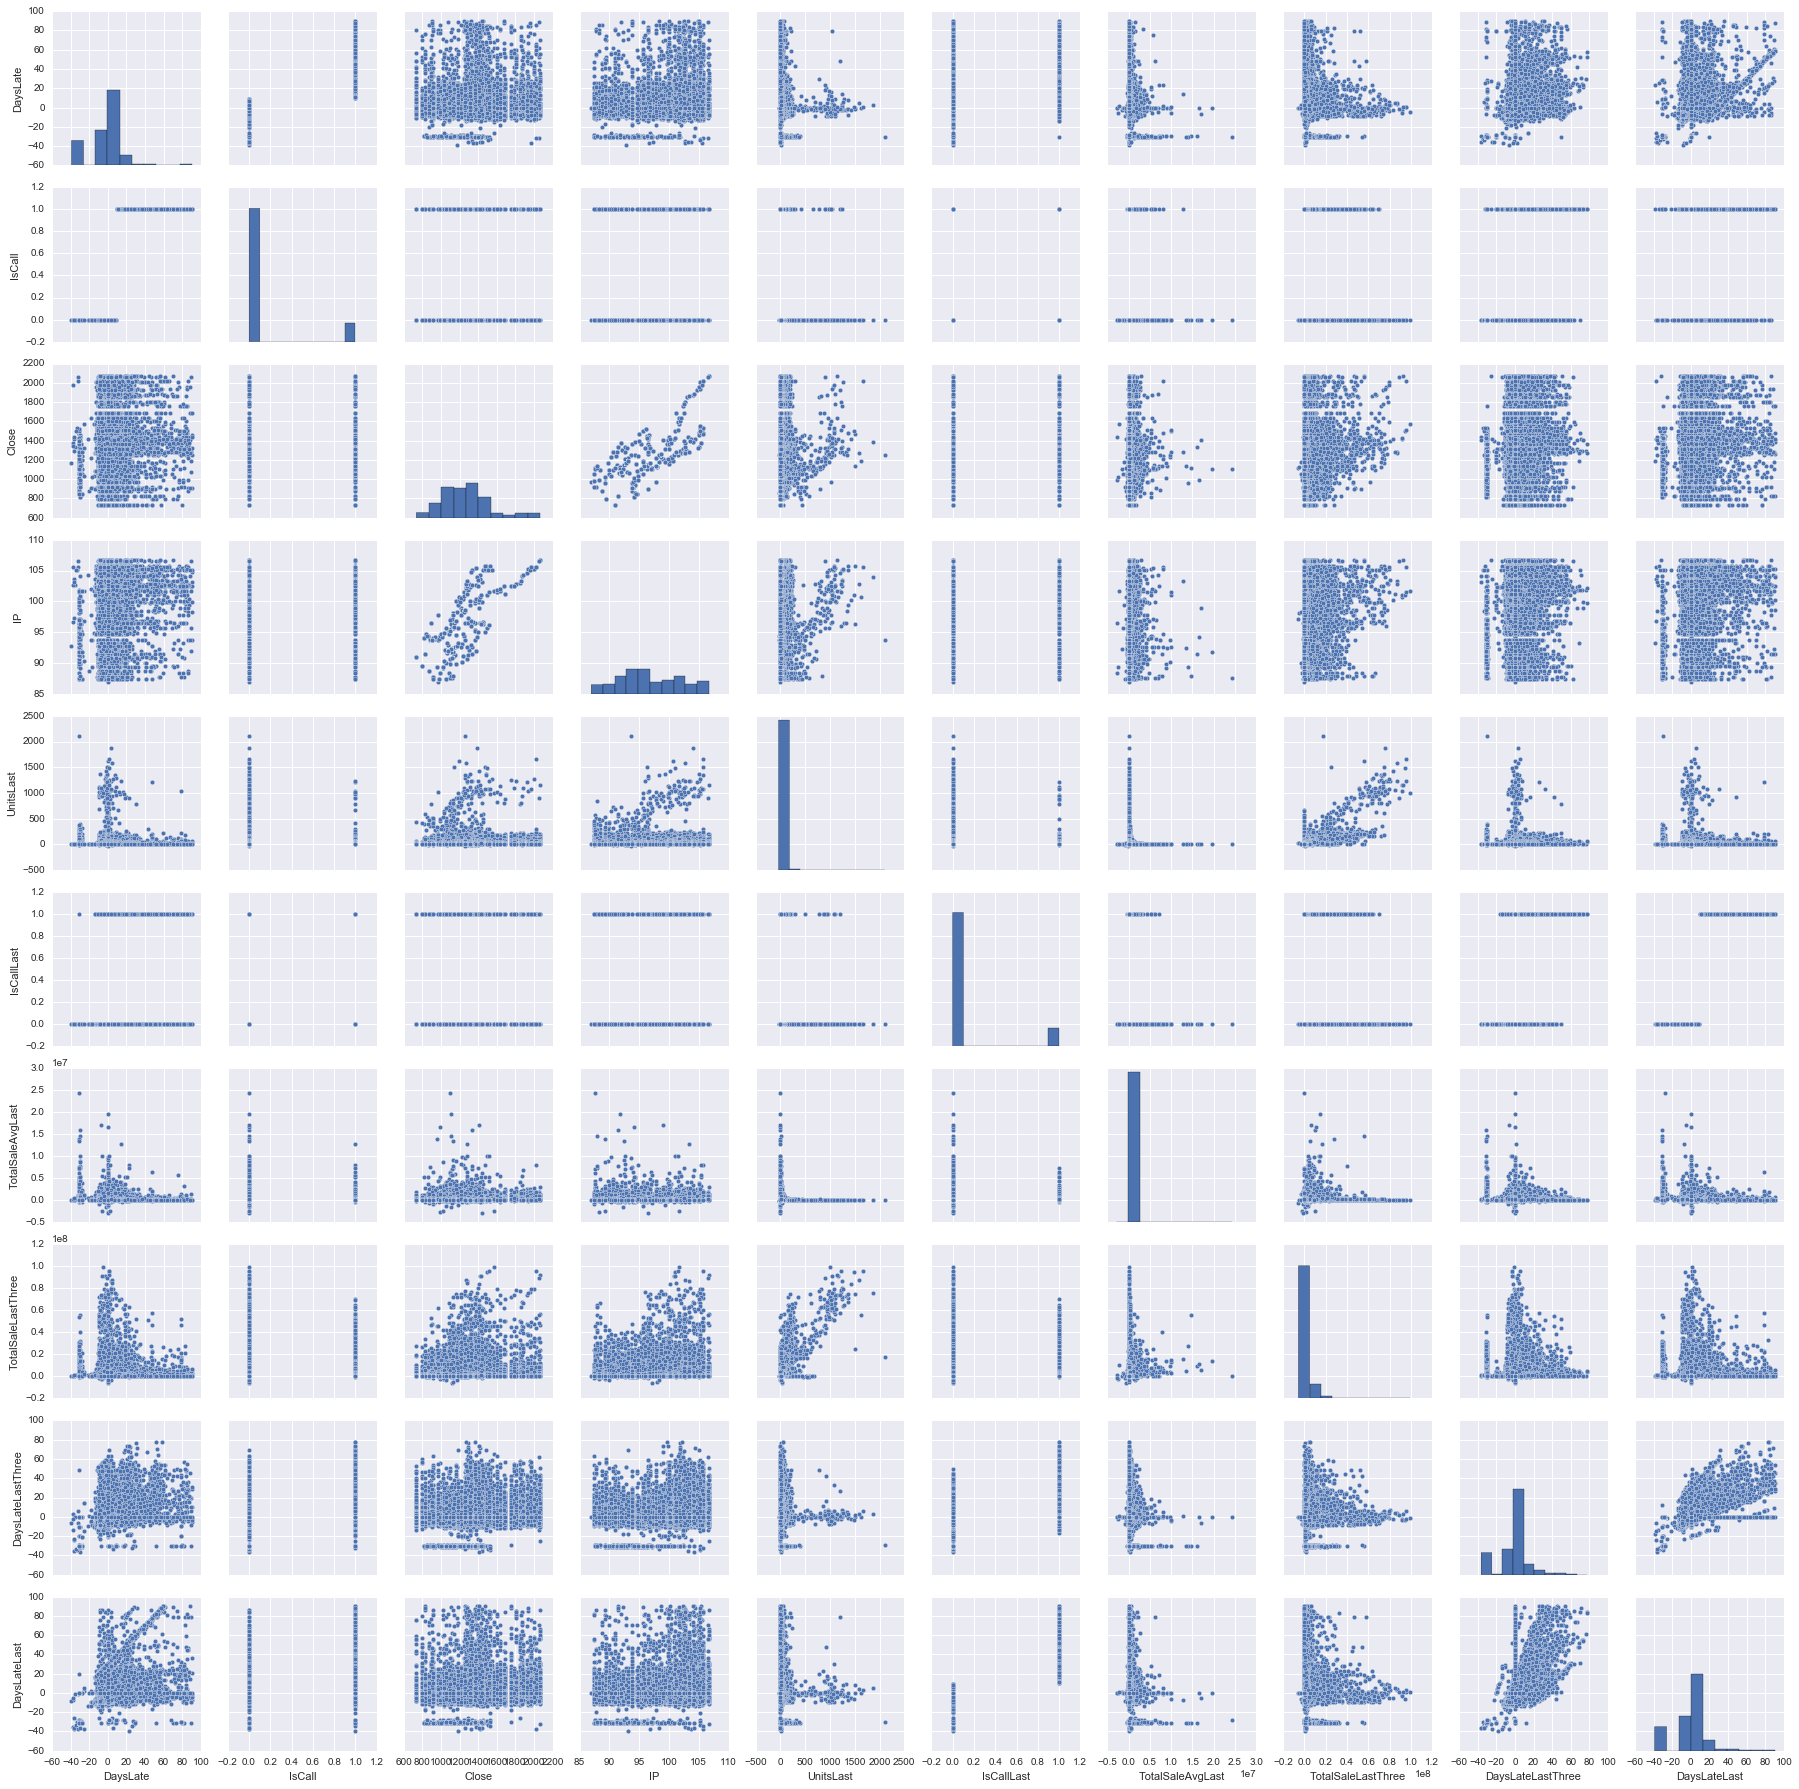

In [84]:
#scatter matrix identifying key features and their relationships - target excluded

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0',axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)

sns.pairplot(PAIRPLOT2)

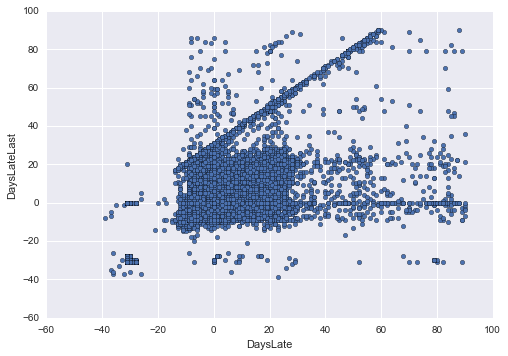

In [85]:
#DaysLate Last vs Days Late (suspicious line was investigated - business reason for this, not data error)

AAID_BY_MONTH_NO_BACKFILL.plot.scatter('DaysLate','DaysLateLast')

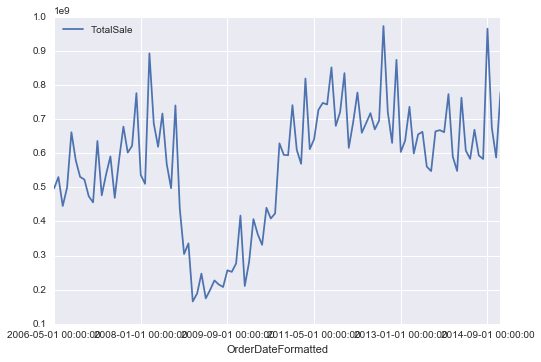

In [86]:
#average sales over time

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).sum()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='TotalSale')

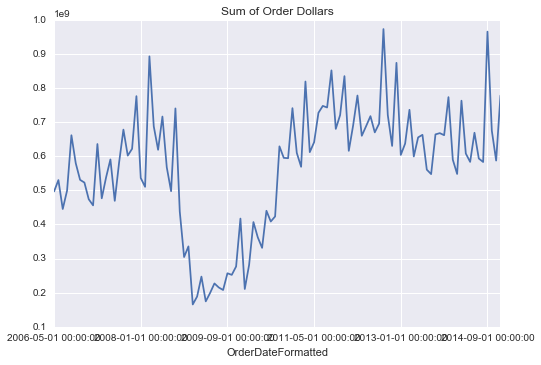

In [87]:
#plot of orders submitted over time

USMTO_WHOLE.groupby(['OrderDateFormatted'])['TotalSale'].sum().plot(kind = 'line', title = 'Sum of Order Dollars')

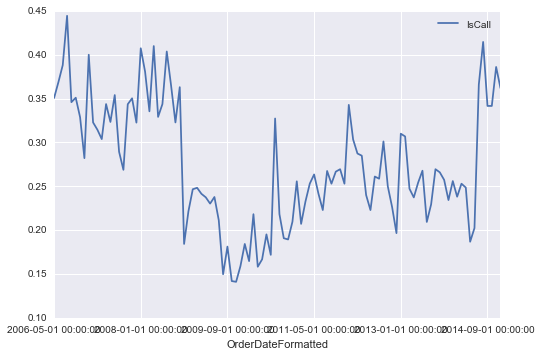

In [88]:
#percentage of company by month who needed to be called

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsCall')

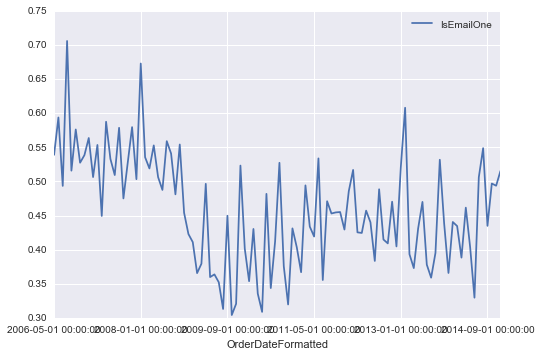

In [89]:
#percentage of company by month who needed to have first email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailOne')

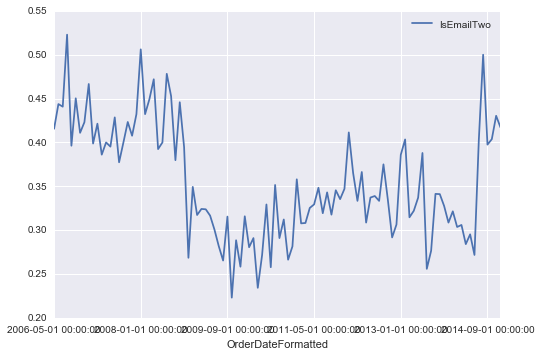

In [90]:
#percentage of company by month who needed to have second email sent

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsEmailTwo')

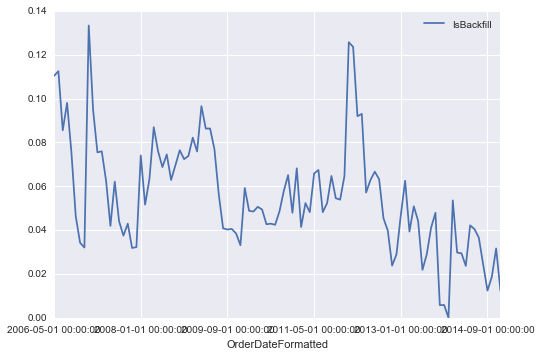

In [91]:
#percentage of company by month who backfilled

BY_MONTH = AAID_BY_MONTH.groupby(['OrderDateFormatted']).mean()
BY_MONTH.reset_index(level=1, inplace=True)
BY_MONTH.plot(x='OrderDateFormatted', y='IsBackfill')

In [92]:
#shows columns we are working with in new dataset

PAIRPLOT2.columns

Index(['DaysLate', 'IsCall', 'Close', 'IP', 'UnitsLast', 'IsCallLast',
       'TotalSaleAvgLast', 'TotalSaleLastThree', 'DaysLateLastThree',
       'DaysLateLast'],
      dtype='object')

In [156]:
#prep for correlation matrix - target included. also the dataframe for machine learning algorithms

PAIRPLOT2 = AAID_BY_MONTH_NO_BACKFILL
PAIRPLOT2 = PAIRPLOT2.drop('AAID', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('OrderDateFormatted', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailOne', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsEmailTwo', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('IsBackfill', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLate', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('DaysLateLast', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSaleAvg', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Units', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('TotalSale', axis = 1)
PAIRPLOT2 = PAIRPLOT2.drop('Unnamed: 0', axis = 1)

corr2 = PAIRPLOT2.corr(method = 'pearson')

In [157]:
#Class Distribution

AAID_BY_MONTH_NO_BACKFILL.groupby('IsCall').size()

IsCall
0    30225
1     4196
dtype: int64

In [158]:
#Skew of Attributes

PAIRPLOT2.skew()

IsCall                 2.311402
Close                  0.835570
IP                     0.102091
UnitsLast             13.460859
IsCallLast             2.356103
TotalSaleAvgLast      17.264811
TotalSaleLastThree     6.459864
DaysLateLastThree      0.000891
dtype: float64

In [159]:
#correlation matrix

PAIRPLOT2.corr()

,IsCall,Close,IP,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLateLastThree
IsCall,1.000000,0.203681,0.303517,0.000187,0.545939,0.031652,0.035714,0.414792
Close,0.203681,1.000000,0.700408,0.053814,0.197086,0.034381,0.108681,0.157593
IP,0.303517,0.700408,1.000000,0.063554,0.293172,0.027511,0.124087,0.362939
UnitsLast,0.000187,0.053814,0.063554,1.000000,0.002864,-0.041987,0.747190,0.040660
IsCallLast,0.545939,0.197086,0.293172,0.002864,1.000000,0.030410,0.038466,0.536899
TotalSaleAvgLast,0.031652,0.034381,0.027511,-0.041987,0.030410,1.000000,0.115792,0.005329
TotalSaleLastThree,0.035714,0.108681,0.124087,0.747190,0.038466,0.115792,1.000000,0.078496
DaysLateLastThree,0.414792,0.157593,0.362939,0.040660,0.536899,0.005329,0.078496,1.000000


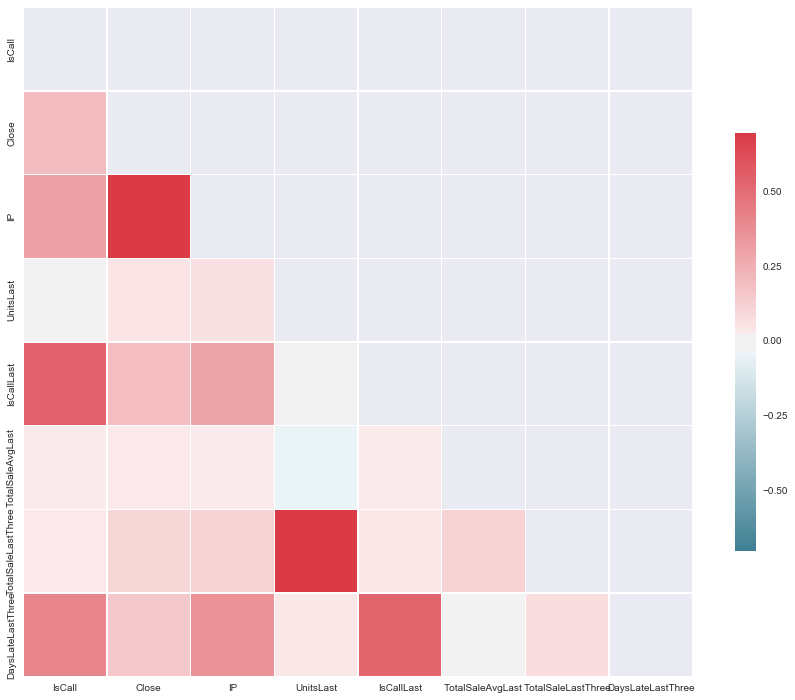

In [160]:
#Correlation Matrix Plot
import matplotlib.pyplot as plt

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.7,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


In [179]:
#shows key characteristics of the dataset we will run through ML models

PAIRPLOT2.describe()

,IsCall,Close,IP,UnitsLast,IsCallLast,TotalSaleAvgLast,TotalSaleLastThree,DaysLateLastThree
count,34421.000000,34421.000000,34421.000000,34421.000000,34421.000000,3.442100e+04,3.442100e+04,34421.000000
mean,0.121902,1271.352003,96.787987,19.318526,0.118823,2.124751e+05,2.779693e+06,-2.257721
std,0.327178,258.753713,5.059148,69.135550,0.323585,4.786152e+05,6.270786e+06,14.556697
min,0.000000,735.090027,86.945400,-34.000000,0.000000,-2.802056e+06,-5.691504e+06,-36.333333
25%,0.000000,1104.239990,92.951700,3.000000,0.000000,5.937617e+04,3.823700e+05,-4.333333
50%,0.000000,1249.479980,96.256200,7.000000,0.000000,1.194976e+05,1.056368e+06,0.000000
75%,0.000000,1400.630005,101.224500,16.000000,0.000000,2.312968e+05,2.573025e+06,0.000000
max,1.000000,2067.560059,106.686800,2110.000000,1.000000,2.440000e+07,9.903093e+07,77.666667


In [162]:
# Feature Importance with Extra Trees Classifier

from sklearn.ensemble import ExtraTreesClassifier
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

# feature extraction

model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.08765407  0.10576834  0.10677125  0.25371302  0.1220567   0.1186505
  0.20538611]


In [163]:
# Feature Extraction with RFE 

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# load data

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features: " , fit.n_features_)
print("Selected Features: " , fit.support_)
print("Feature Ranking: " , fit.ranking_)

Num Features:  4
Selected Features:  [ True  True False  True False False  True]
Feature Ranking:  [1 1 2 1 3 4 1]


In [176]:
#tags just the features

a = pd.DataFrame({'Close':X[:,0],'IP':X[:,1],'UnitsLast':X[:,2],'IsCallLast':X[:,3],'TotalSaleAvgLast':X[:,4],'TotalSaleLastThree':X[:,5],'DaysLateLastThree':X[:,6]}).head()


Index(['Close', 'DaysLateLastThree', 'IP', 'IsCallLast', 'TotalSaleAvgLast',
       'TotalSaleLastThree', 'UnitsLast'],
      dtype='object')
Index(['IsCall', 'Close', 'IP', 'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast',
       'TotalSaleLastThree', 'DaysLateLastThree'],
      dtype='object')


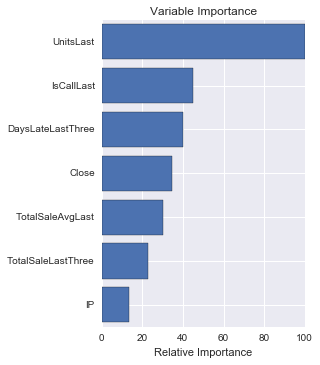

In [178]:
# Plot feature importance

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, Y_train)

feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, a.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [166]:
#we end up using all features as there are not too many to begin with and no one feature appears to be terrible

In [167]:
#test different types of models

array = PAIRPLOT2.values
X = array[:,1:14].astype(float)
Y = array[:,0]
validation_size = 0.33
seed = 7
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y,
test_size=validation_size, random_state=seed)
num_folds = 5
num_instances = len(X_train)
seed = 7
scoring = 'accuracy'
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('KNNWeighted', KNeighborsClassifier(weights='distance')))
models.append(('CART', DecisionTreeClassifier()))
models.append(('CART Max Depth 5', DecisionTreeClassifier(max_depth= 5)))
models.append(('NB', GaussianNB()))
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = (name, cv_results.mean(),cv_results.std())
    print(msg)


('LR', 0.87828501939069203, 0.0050219671285226496)
('LDA', 0.9036509156501602, 0.0044505748569166163)
('KNN', 0.8654068435502893, 0.0062452685095405365)
('KNNWeighted', 0.8504905721960393, 0.0070389732039164363)
('CART', 0.87611638664365155, 0.0058778073170776832)
('CART Max Depth 5', 0.91223661062696793, 0.0028731052020948959)
('NB', 0.87828501939069203, 0.0050219671285226496)


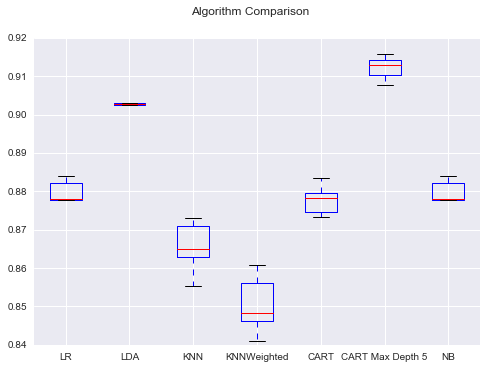

In [122]:
#distribution of models, accuracy and std dev

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [180]:
#exports decision tree for viewing - we see that it's massive and indicates overfitting

from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, Y_train)
tree.export_graphviz(clf, out_file='decisiontree.dot',feature_names = a.columns)   

In [181]:
#exports decision tree for viewing - we see that it's massive and indicates overfitting

from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth = 5)
clf = clf.fit(X_train, Y_train)
tree.export_graphviz(clf, out_file='decisiontreebetter.dot',feature_names = a.columns)   

In [107]:
#classification report with kNN

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.88      0.98      0.93      9970
        1.0       0.24      0.04      0.07      1389

avg / total       0.80      0.87      0.82     11359



In [108]:
#classification report with CART 

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.93      0.93      0.93      9970
        1.0       0.52      0.53      0.52      1389

avg / total       0.88      0.88      0.88     11359



In [109]:
#classification report with CART with max depth of 5

from sklearn.metrics import classification_report

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = DecisionTreeClassifier(max_depth = 5)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.93      0.98      0.95      9970
        1.0       0.74      0.48      0.58      1389

avg / total       0.91      0.92      0.91     11359



In [110]:
#classification report with Logistic Regression

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LogisticRegression()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.88      1.00      0.93      9970
        1.0       0.00      0.00      0.00      1389

avg / total       0.77      0.88      0.82     11359



C:\Users\lzhang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [111]:
#classification report with Linear Discriminant Analysis

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.94      0.95      0.95      9970
        1.0       0.61      0.59      0.60      1389

avg / total       0.90      0.90      0.90     11359



In [112]:
#classification report with Naive Bayes

array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
test_size = 0.33
seed = 7
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y,
test_size=test_size, random_state=seed)
model = GaussianNB()
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

        0.0       0.88      1.00      0.93      9970
        1.0       0.00      0.00      0.00      1389

avg / total       0.77      0.88      0.82     11359



C:\Users\lzhang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [113]:
# Cross Validation Classification LogLoss (smaller logloss better with 0 as perfect logloss)


from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = LinearDiscriminantAnalysis()
scoring = 'log_loss'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("Logloss: ", results.mean(), "      Std Dev: ", results.std()*100.0)

Logloss:  -0.352492174291       Std Dev:  20.5929910344


In [129]:
# ROC 

from sklearn import cross_validation
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]
num_folds = 10
num_instances = len(X)
seed = 7
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
model = DecisionTreeClassifier(max_depth = 5)
scoring = 'roc_auc'
results = cross_validation.cross_val_score(model, X, Y, cv=kfold, scoring = scoring)
print("AUC: ", results.mean(), "      Std Dev: ", results.std()*100.0)


AUC:  0.920497468957       Std Dev:  4.7275137028


Neighbors: 1, Accuracy: 0.794080
Neighbors: 3, Accuracy: 0.846725
Neighbors: 5, Accuracy: 0.865482
Neighbors: 7, Accuracy: 0.873645
Neighbors: 9, Accuracy: 0.876242
Neighbors: 11, Accuracy: 0.877561
Neighbors: 13, Accuracy: 0.877808
Neighbors: 15, Accuracy: 0.878262
Neighbors: 17, Accuracy: 0.878427
Neighbors: 19, Accuracy: 0.878509
Neighbors: 21, Accuracy: 0.878551
Neighbors: 23, Accuracy: 0.878674
Neighbors: 25, Accuracy: 0.878427
Neighbors: 27, Accuracy: 0.878427
Neighbors: 29, Accuracy: 0.878427
Neighbors: 31, Accuracy: 0.878427
Neighbors: 33, Accuracy: 0.878427
Neighbors: 35, Accuracy: 0.878427
Neighbors: 37, Accuracy: 0.878427
Neighbors: 39, Accuracy: 0.878427
Neighbors: 41, Accuracy: 0.878427
Neighbors: 43, Accuracy: 0.878427
Neighbors: 45, Accuracy: 0.878427
Neighbors: 47, Accuracy: 0.878427
Neighbors: 49, Accuracy: 0.878427


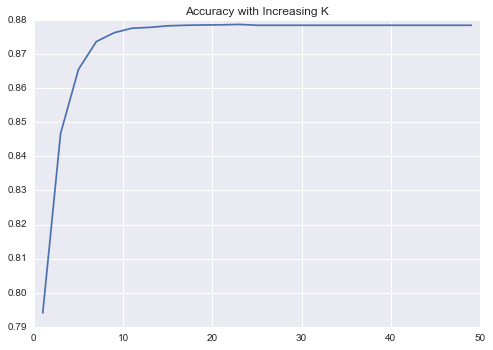

In [119]:
#select optimal K

from sklearn.neighbors import KNeighborsClassifier

df = PAIRPLOT2

test_idx = np.random.uniform(0, 1, len(df)) <= 0.3
train = df[test_idx==True]
test = df[test_idx==False]

features = ['Close', 'IP',
       'UnitsLast', 'IsCallLast', 'TotalSaleAvgLast', 'TotalSaleLastThree',
       'DaysLateLastThree']

results = []
for n in range(1, 51, 2):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(train[features], train['IsCall'])
    preds = clf.predict(test[features])
    accuracy = np.where(preds==test['IsCall'], 1, 0).sum() / float(len(test))
    print ("Neighbors: %d, Accuracy: %3f" % (n, accuracy))

    results.append([n, accuracy])

results = pd.DataFrame(results, columns=["n", "accuracy"])

plt.plot(results.n, results.accuracy)
plt.title("Accuracy with Increasing K")
plt.show()

In [ ]:
********BREAK**********#experimental below

In [ ]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


In [ ]:
# Import some data to play with

array = PAIRPLOT2.values
X = array[:,1:14]
y = array[:,0]

# Binarize the output
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)


In [ ]:
predicted.shape

In [ ]:
Y_test.shape

In [ ]:
Y_train.shape

In [ ]:
Y_validation.shape

In [ ]:
X_test.shape

In [ ]:
X_train.shape

In [ ]:
n_classes

In [ ]:
predicted.tofile('predicted.xls',sep = ",")

In [ ]:
Y_test.tofile('ytest.xls',sep = ",")

In [ ]:
Y_validation.tofile('validation.xls',sep = ',')

In [ ]:
roc_curve?

In [ ]:

# Compute ROC curve and ROC area for each class
array = PAIRPLOT2.values
X = array[:,1:14]
Y = array[:,0]

n_classes = Y.shape[0]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(predicted.shape[0]):
    fpr[i], tpr[i] = roc_curve(Y_test[:, i], predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()